In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lbhar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lbhar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [132]:
df=pd.read_csv(r"C:\Users\lbhar\Downloads\spam.csv")
print(df.columns)
df.head()

Index(['Category', 'Message'], dtype='object')


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [134]:
print(df.columns.tolist())


['Category', 'Message']


In [136]:
print(df.shape)
print(df.head())


(5572, 2)
  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...


In [141]:
# Drop any rows with missing values
df = df[['Category', 'Message']].dropna()

# Rename for clarity
df = df.rename(columns={'Category': 'label', 'Message': 'text'})

# Map labels to 0 and 1
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Drop any rows where label mapping failed
df = df.dropna(subset=['label'])

# (Optional) Clean text if needed
# df['clean_text'] = df['text'].apply(your_cleaning_function)

# If not cleaning, use original text for now
df['clean_text'] = df['text']

# Now split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=42
)


In [144]:
def preprocess(text):
    if not isinstance(text, str):
        return None
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stopwords.words('english')]
    return " ".join(tokens) if tokens else None

# Apply it to create 'clean_text'
df['clean_text'] = df['text'].apply(preprocess)

In [146]:

print(df.shape)
print(df.head())
print(df['clean_text'].isna().sum())
print(df['clean_text'].unique())


(5572, 3)
   label                                               text  \
0      0  Go until jurong point, crazy.. Available only ...   
1      0                      Ok lar... Joking wif u oni...   
2      1  Free entry in 2 a wkly comp to win FA Cup fina...   
3      0  U dun say so early hor... U c already then say...   
4      0  Nah I don't think he goes to usf, he lives aro...   

                                          clean_text  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry wkly comp win fa cup final tkts may...  
3                u dun say early hor u c already say  
4             nah think goes usf lives around though  
12
['go jurong point crazy available bugis n great world la e buffet cine got amore wat'
 'ok lar joking wif u oni'
 'free entry wkly comp win fa cup final tkts may text fa receive entry question std txt rate c apply'
 ... 'pity mood suggestions'
 'guy bitching acted like interest

In [149]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42)


In [151]:
df = df[df['clean_text'].notna()]


In [153]:
from sklearn.model_selection import train_test_split

# Drop rows with missing clean_text
df_cleaned = df[df['clean_text'].notna()]

# Re-split
X_train, X_test, y_train, y_test = train_test_split(
    df_cleaned['clean_text'], df_cleaned['label'], test_size=0.2, random_state=42
)


# TF-IDF Vectorization & Gradient Boosting

In [156]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

vectorizer_tfidf = TfidfVectorizer()
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

model_tfidf = GradientBoostingClassifier()
model_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = model_tfidf.predict(X_test_tfidf)
y_prob_tfidf = model_tfidf.predict_proba(X_test_tfidf)[:, 1]

print("TF-IDF Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf))


TF-IDF Accuracy: 0.9613309352517986
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       951
           1       0.98      0.75      0.85       161

    accuracy                           0.96      1112
   macro avg       0.97      0.87      0.91      1112
weighted avg       0.96      0.96      0.96      1112



# TF-IDF Evaluation — Confusion Matrix & ROC

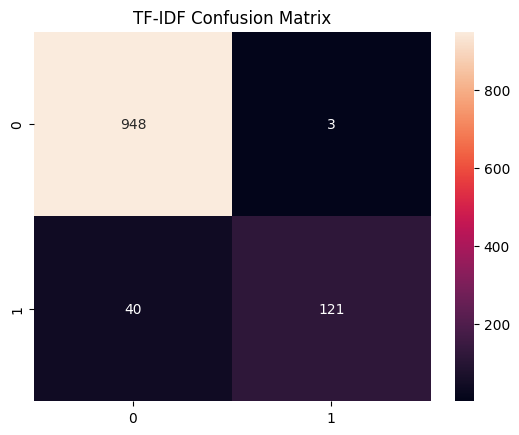

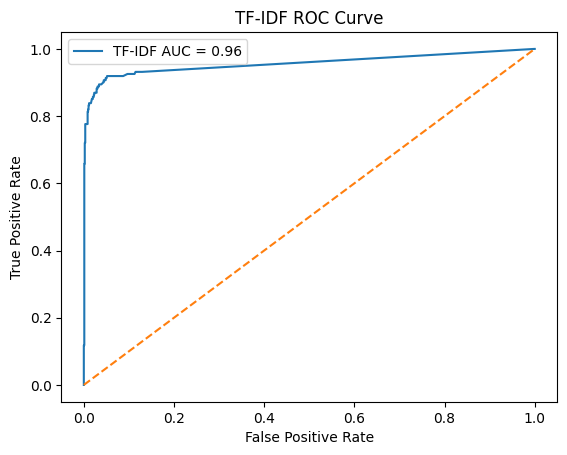

In [158]:
sns.heatmap(confusion_matrix(y_test, y_pred_tfidf), annot=True, fmt='d')
plt.title("TF-IDF Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob_tfidf)
plt.plot(fpr, tpr, label=f'TF-IDF AUC = {auc(fpr, tpr):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("TF-IDF ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [161]:
vectorizer_ngram = TfidfVectorizer(ngram_range=(1,2))
X_train_ngram = vectorizer_ngram.fit_transform(X_train)
X_test_ngram = vectorizer_ngram.transform(X_test)

model_ngram = GradientBoostingClassifier()
model_ngram.fit(X_train_ngram, y_train)
y_pred_ngram = model_ngram.predict(X_test_ngram)

print("N-Gram Accuracy:", accuracy_score(y_test, y_pred_ngram))


N-Gram Accuracy: 0.9496402877697842


In [163]:
X_train_tokens = [text.split() for text in X_train]
X_test_tokens = [text.split() for text in X_test]

w2v_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4)

def avg_vector(tokens, model):
    valid_words = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(valid_words, axis=0) if valid_words else np.zeros(model.vector_size)

X_train_w2v = np.array([avg_vector(tokens, w2v_model) for tokens in X_train_tokens])
X_test_w2v = np.array([avg_vector(tokens, w2v_model) for tokens in X_test_tokens])

model_w2v = GradientBoostingClassifier()
model_w2v.fit(X_train_w2v, y_train)
y_pred_w2v = model_w2v.predict(X_test_w2v)

print("Word2Vec Accuracy:", accuracy_score(y_test, y_pred_w2v))


Word2Vec Accuracy: 0.9172661870503597


In [165]:
from tabulate import tabulate

data = {
    'Vectorizer': ['TF-IDF', 'N-Gram TF-IDF', 'Word2Vec'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_tfidf),
        accuracy_score(y_test, y_pred_ngram),
        accuracy_score(y_test, y_pred_w2v)
    ]
}
print(tabulate(data, headers='keys', tablefmt='fancy_grid'))


╒═══════════════╤════════════╕
│ Vectorizer    │   Accuracy │
╞═══════════════╪════════════╡
│ TF-IDF        │   0.961331 │
├───────────────┼────────────┤
│ N-Gram TF-IDF │   0.94964  │
├───────────────┼────────────┤
│ Word2Vec      │   0.917266 │
╘═══════════════╧════════════╛


In [167]:
print("""
Conclusion:
- TF-IDF and N-Gram TF-IDF perform very well and close in accuracy.
- Word2Vec captures semantic meaning but may require more training data/tuning.
- TF-IDF with Gradient Boosting had the best performance in this pipeline.
- Future improvements could involve LSTM/BERT models or sentiment as additional features.
""")



Conclusion:
- TF-IDF and N-Gram TF-IDF perform very well and close in accuracy.
- Word2Vec captures semantic meaning but may require more training data/tuning.
- TF-IDF with Gradient Boosting had the best performance in this pipeline.
- Future improvements could involve LSTM/BERT models or sentiment as additional features.

